In [50]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm

In [49]:
!pip install tqdm

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
#Nếu có GPU

In [4]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform ={
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale =(0.5,1.0)),
                transforms.RandomHorizontalFlip(0.7),#xác xuất xoay ảnh
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            
            'val' :transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                #dùng tab để gợi ý
            ])
        }
    def __call__(self, img, phase = 'train'):
        return self.data_transform[phase](img)

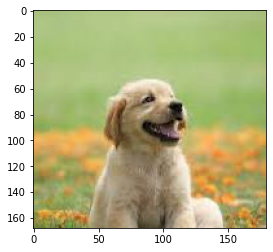

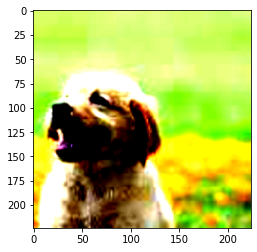

In [5]:
img_file_path = r'C:\Users\admin\Workspace\pytorch prj\puppy_image.jpg'
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(resize, mean, std)
img_transformed = transform(img,phase ='train')


#chanel, height, width -> height, width, chanel -> (0,1)
img_transformed = img_transformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [6]:
def make_datapath_list(phase = 'train'):
    rootpath = r'./data/hymenoptera_data/'
    target_path = osp.join(rootpath+phase+"/**/*.jpg")
    
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list
    

In [7]:
path_list = make_datapath_list("train")

In [8]:
len(path_list)

243

In [9]:
path_list[:10]

['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg']

In [10]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

In [11]:
class MyDataset(data.Dataset):
    def __init__(self,file_list,transform = None, phase ='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img =Image.open(img_path)
        
        img_transformed = self.transform(img,self.phase)
        
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase =="val":
            label = img_path[28:32]
            
        if label == "ants":
            label = 0
        elif label =="bees":
            label = 1
        
        return img_transformed, label

In [12]:
train_dataset = MyDataset(train_list, transform = ImageTransform(resize,mean,std),phase = "train")

In [13]:
val_dataset = MyDataset(val_list, transform = ImageTransform(resize,mean,std),phase = "val")

In [14]:
index = 0
#print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


In [25]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle = False)

dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

In [26]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels = next(batch_iterator)

In [27]:
print(inputs.size())
print(labels)

torch.Size([8, 3, 224, 224])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


# NETWORK

In [30]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
#print(net)
net.classifier[6] = nn.Linear(in_features = 4096, out_features = 2)

#setting mode

net = net.train()

# Loss

In [31]:
criterior = nn.CrossEntropyLoss()

# optimizer

In [39]:
params_to_update = []

update_params_name = ["classifier.6.weight","classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[ 1.0049e-02, -1.3921e-02, -2.4289e-03,  ...,  1.2562e-03,
         -1.2282e-02,  1.5596e-02],
        [-8.6589e-04, -1.3969e-02,  8.7887e-03,  ...,  5.2733e-05,
         -4.8891e-03, -1.5413e-02]], requires_grad=True), Parameter containing:
tensor([-3.7193e-05, -9.1663e-03], requires_grad=True)]


In [40]:
optimizer = optim.SGD(params = params_to_update, lr = 0.001, momentum = 0.9)
#chú ý lr không đc quá lớn hay quá nhỏ
#optimizer

In [53]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}")
        
        for phase in ["train", "val"]:
            if phase =="train":
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if(epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase,epoch_loss, epoch_accuracy))

In [54]:
num_epochs = 2
train_model(net,dataloader_dict,criterior,optimizer, num_epochs)

Epoch 0/2


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.08s/it]


val Loss: 0.6917 Acc: 0.5752
Epoch 1/2


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:38<00:00,  5.10s/it]


train Loss: 0.2609 Acc: 0.8519


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.18s/it]

val Loss: 0.1265 Acc: 0.9477
